# Comprehensive Graph Expressiveness Benchmark Dataset

**Demo notebook** for the graph expressiveness benchmark containing 525 non-isomorphic graph pairs across 4 families:
- **Cospectral pairs** (64): eigenvalue-identical but structurally distinct graphs
- **CSL circulant graphs** (59): 1-WL indistinguishable circular skip link graphs
- **Strongly regular graphs** (2): Shrikhande and Chang graph pairs
- **BREC benchmark pairs** (400): spanning Basic/Regular/Extension/CFI/4-Vertex/Distance-Regular categories

Each pair includes adjacency matrices, edge lists, eigenvalues, cospectrality flags, and WL-level annotations. This dataset directly supports testing whether Koopman Walk PEs can distinguish graph pairs that spectral-invariant methods cannot.

**Source**: Generated programmatically via NetworkX and loaded from official BREC repository (arXiv:2304.07702).

In [1]:
# Install dependencies
import subprocess, sys

_in_colab = "google.colab" in sys.modules
pkgs = ["numpy", "networkx", "matplotlib"]
if _in_colab:
    # numpy is pre-installed in Colab
    pkgs = [p for p in pkgs if p != "numpy"]
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)
print("All dependencies installed.")


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


All dependencies installed.


In [2]:
# Imports
import json
import sys
import os
import collections

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

print(f"numpy {np.__version__}, networkx {nx.__version__}")

numpy 2.4.2, networkx 3.6.1


## Load Data

Load the mini demo dataset (14 representative graph pairs) from GitHub, with a local fallback.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/dataset_iter1_comprehensive_g/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded dataset: {data['metadata']['title']}")
print(f"Total pairs in mini demo: {len(data['datasets'][0]['examples'])}")

Loaded dataset: Comprehensive Graph Expressiveness Benchmark Dataset
Total pairs in mini demo: 14


## Configuration

Tunable parameters for dataset processing and visualization.

In [5]:
# --- Configuration ---
NUM_FOLDS = 5                # Number of cross-validation folds
MAX_PAIRS_TO_VISUALIZE = 4   # Max graph pairs to visualize in detail (nodes <= 16)
MAX_EIGENVALUE_PAIRS = 4     # Max pairs for eigenvalue comparison plot

## Data Enrichment and Validation

Assign fold numbers and row indices to each example, then validate the schema structure. This mirrors the original `data.py` standardization pipeline.

In [6]:
# Extract examples from the loaded data
all_examples = data["datasets"][0]["examples"]
print(f"Total examples loaded: {len(all_examples)}")

# Assign fold numbers and row indices (mirroring data.py)
enriched = []
for i, ex in enumerate(all_examples):
    ex_copy = dict(ex)
    ex_copy["metadata_fold"] = i % NUM_FOLDS
    ex_copy["metadata_row_index"] = i
    ex_copy["metadata_task_type"] = "graph_pair_classification"
    enriched.append(ex_copy)

# Validate structure
for ex in enriched:
    assert "input" in ex and isinstance(ex["input"], str)
    assert "output" in ex and isinstance(ex["output"], str)
    for key in ex:
        if key not in ("input", "output") and not key.startswith("metadata_"):
            raise ValueError(f"Invalid key '{key}' in example {ex.get('metadata_pair_id')}")

print(f"Enriched and validated {len(enriched)} examples")
print(f"Fold distribution: {collections.Counter(ex['metadata_fold'] for ex in enriched)}")

Total examples loaded: 14
Enriched and validated 14 examples
Fold distribution: Counter({0: 3, 1: 3, 2: 3, 3: 3, 4: 2})


## Dataset Statistics

Summarize the benchmark by category, difficulty, and WL-level.

In [7]:
# Parse each example's input/output for analysis
parsed_pairs = []
for ex in enriched:
    inp = json.loads(ex["input"])
    out = json.loads(ex["output"])
    parsed_pairs.append({
        "pair_id": ex.get("metadata_pair_id", "unknown"),
        "category": ex.get("metadata_category", "unknown"),
        "subcategory": ex.get("metadata_subcategory", "unknown"),
        "difficulty": ex.get("metadata_difficulty", "unknown"),
        "wl_level": ex.get("metadata_wl_level", "unknown"),
        "nodes_A": inp["graph_A"]["num_nodes"],
        "nodes_B": inp["graph_B"]["num_nodes"],
        "edges_A": inp["graph_A"]["num_edges"],
        "edges_B": inp["graph_B"]["num_edges"],
        "is_isomorphic": out["is_isomorphic"],
        "are_cospectral": out["are_cospectral"],
        "eigenvalues_A": inp["graph_A"].get("eigenvalues", []),
        "eigenvalues_B": inp["graph_B"].get("eigenvalues", []),
        "adj_A": inp["graph_A"]["adjacency_matrix"],
        "adj_B": inp["graph_B"]["adjacency_matrix"],
        "edges_list_A": inp["graph_A"]["edge_list"],
        "edges_list_B": inp["graph_B"]["edge_list"],
    })

# Summary table
print(f"{'Category':<25} {'Subcategory':<20} {'Difficulty':<10} {'WL Level':<8} {'Nodes A':<8} {'Cospectral'}")
print("-" * 100)
for p in parsed_pairs:
    print(f"{p['category']:<25} {p['subcategory']:<20} {p['difficulty']:<10} {p['wl_level']:<8} {p['nodes_A']:<8} {p['are_cospectral']}")

# Aggregate stats
cat_counts = collections.Counter(p["category"] for p in parsed_pairs)
diff_counts = collections.Counter(p["difficulty"] for p in parsed_pairs)
wl_counts = collections.Counter(p["wl_level"] for p in parsed_pairs)
cospec_counts = collections.Counter(p["are_cospectral"] for p in parsed_pairs)

print(f"\nCategory distribution: {dict(cat_counts)}")
print(f"Difficulty distribution: {dict(diff_counts)}")
print(f"WL-level distribution: {dict(wl_counts)}")
print(f"Cospectral distribution: {dict(cospec_counts)}")
print(f"All pairs are non-isomorphic: {all(not p['is_isomorphic'] for p in parsed_pairs)}")

Category                  Subcategory          Difficulty WL Level Nodes A  Cospectral
----------------------------------------------------------------------------------------------------
cospectral                5_vertex_canonical   easy       1-WL     5        True
cospectral                6_vertex_atlas       easy       1-WL     6        True
cospectral                7_vertex_atlas       medium     1-WL     7        True
CSL                       n16                  easy       1-WL     16       False
CSL                       n41                  medium     1-WL     41       False
strongly_regular          srg_16_6_2_2         hard       2-WL     16       True
strongly_regular          srg_28_12_6_4        hard       2-WL     28       True
BREC_Basic                basic                easy       1-WL     10       False
BREC_Regular              regular              medium     1-WL     10       False
BREC_Extension            extension            medium     2-WL     10       Fal

## Graph Pair Visualization

Visualize selected graph pairs side by side. Each row shows Graph A and Graph B from a pair, highlighting how structurally different non-isomorphic graphs can share spectral properties.

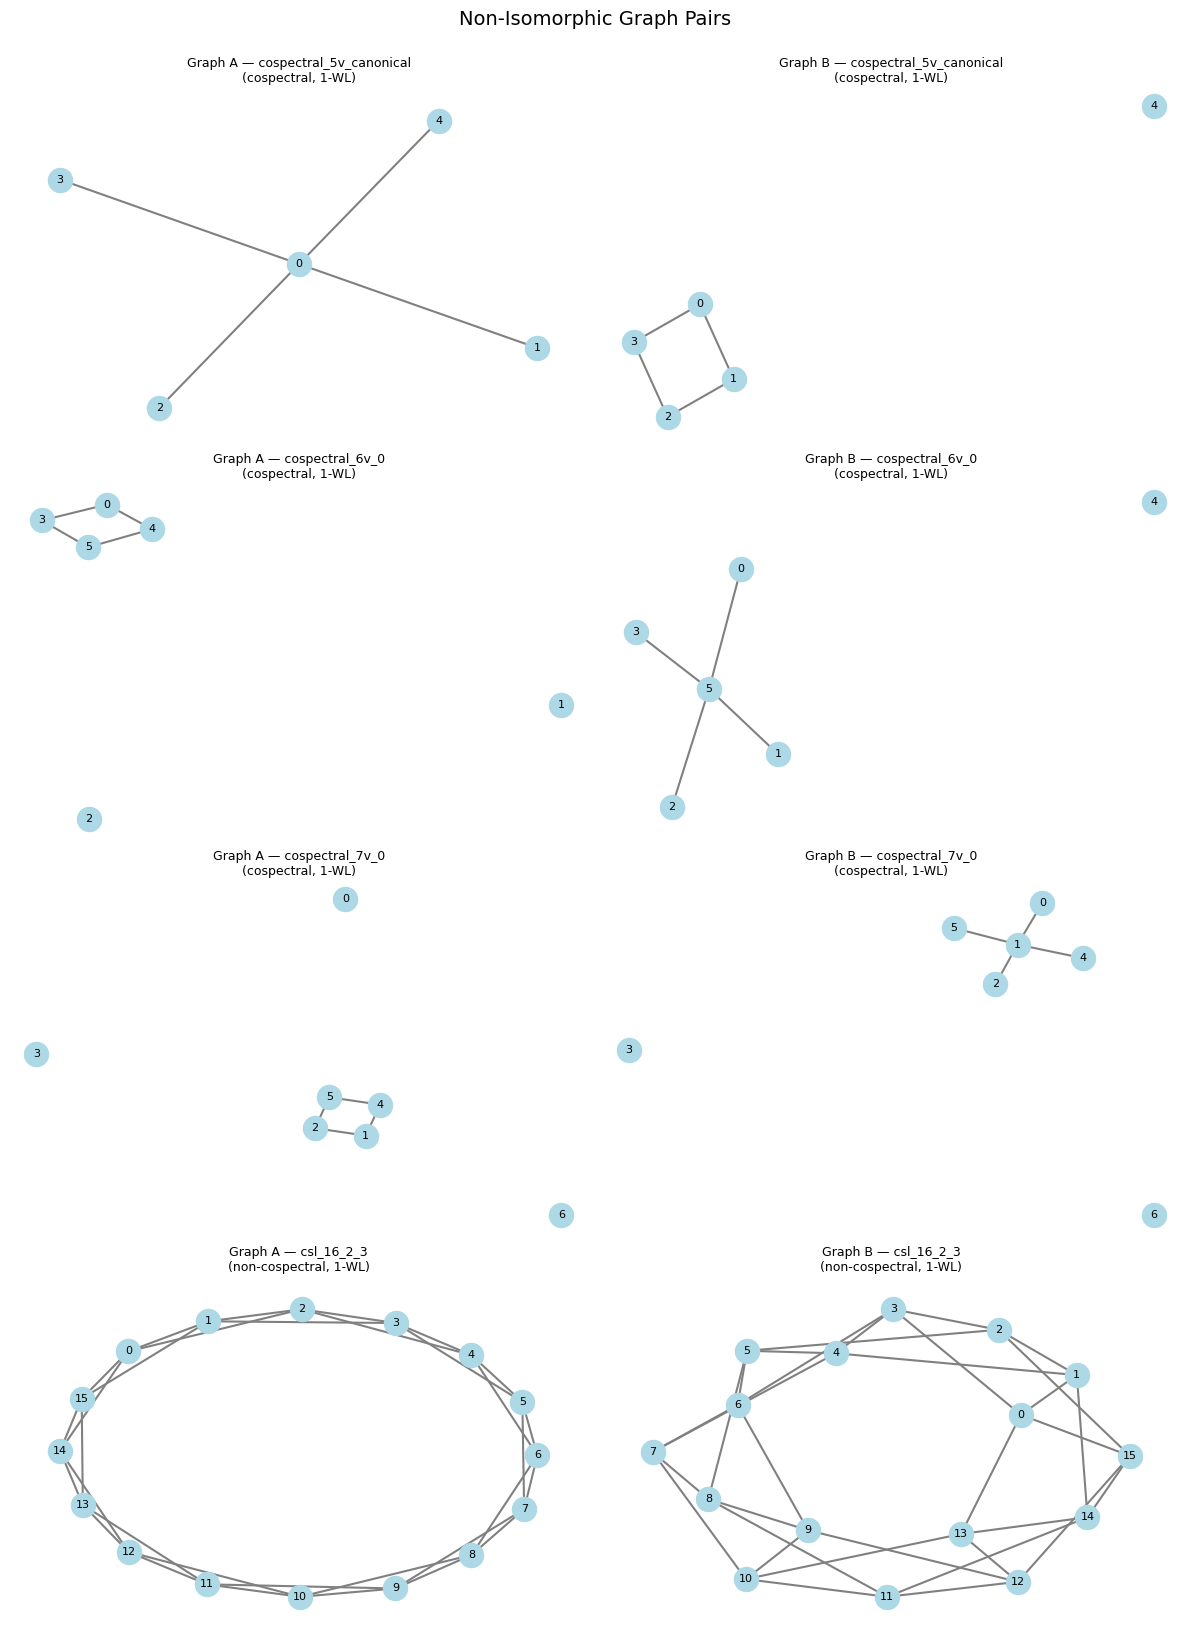

In [8]:
# Visualize graph pairs (select small ones for clarity)
pairs_to_viz = [p for p in parsed_pairs if p["nodes_A"] <= 16][:MAX_PAIRS_TO_VISUALIZE]

fig, axes = plt.subplots(len(pairs_to_viz), 2, figsize=(12, 4 * len(pairs_to_viz)))
if len(pairs_to_viz) == 1:
    axes = [axes]

for row_idx, pair in enumerate(pairs_to_viz):
    for col_idx, (label, edges, n_nodes) in enumerate([
        ("Graph A", pair["edges_list_A"], pair["nodes_A"]),
        ("Graph B", pair["edges_list_B"], pair["nodes_B"]),
    ]):
        ax = axes[row_idx][col_idx]
        G = nx.Graph()
        G.add_nodes_from(range(n_nodes))
        G.add_edges_from(edges)
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, ax=ax, with_labels=True, node_color="lightblue",
                node_size=300, font_size=8, edge_color="gray", width=1.5)
        cospec_label = "cospectral" if pair["are_cospectral"] else "non-cospectral"
        ax.set_title(f"{label} — {pair['pair_id']}\n({cospec_label}, {pair['wl_level']})", fontsize=9)

plt.tight_layout()
plt.suptitle("Non-Isomorphic Graph Pairs", fontsize=14, y=1.02)
plt.show()

## Eigenvalue Comparison

Compare eigenvalue spectra between Graph A and Graph B for selected pairs. Cospectral pairs have identical eigenvalues despite being structurally different — this is exactly what makes them challenging for spectral methods.

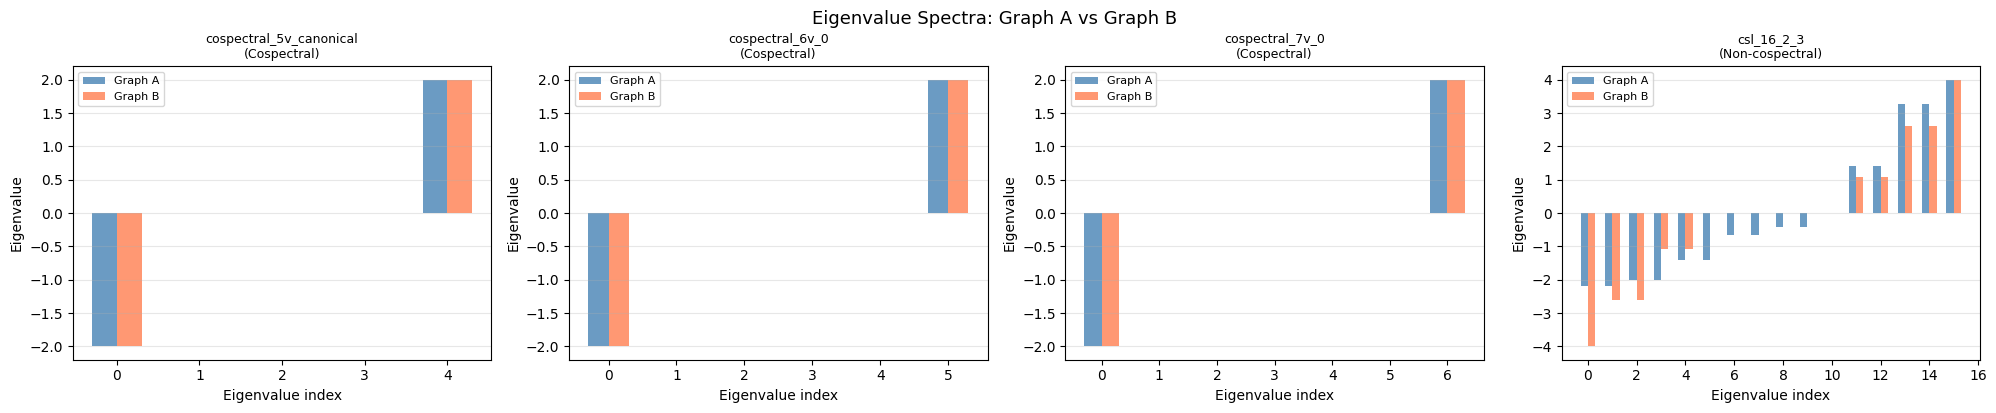

In [9]:
# Eigenvalue comparison for selected pairs
eig_pairs = [p for p in parsed_pairs if p["eigenvalues_A"] and p["eigenvalues_B"]][:MAX_EIGENVALUE_PAIRS]

fig, axes = plt.subplots(1, len(eig_pairs), figsize=(5 * len(eig_pairs), 4))
if len(eig_pairs) == 1:
    axes = [axes]

for idx, pair in enumerate(eig_pairs):
    ax = axes[idx]
    eig_A = sorted(pair["eigenvalues_A"])
    eig_B = sorted(pair["eigenvalues_B"])
    x = np.arange(len(eig_A))

    ax.bar(x - 0.15, eig_A, width=0.3, label="Graph A", alpha=0.8, color="steelblue")
    ax.bar(x + 0.15, eig_B, width=0.3, label="Graph B", alpha=0.8, color="coral")
    ax.set_xlabel("Eigenvalue index")
    ax.set_ylabel("Eigenvalue")
    cospec_str = "Cospectral" if pair["are_cospectral"] else "Non-cospectral"
    ax.set_title(f"{pair['pair_id']}\n({cospec_str})", fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.suptitle("Eigenvalue Spectra: Graph A vs Graph B", fontsize=13, y=1.02)
plt.show()

## Adjacency Matrix Heatmaps

Visualize the adjacency matrices for selected graph pairs as heatmaps. This reveals the structural differences that spectral methods fail to capture.

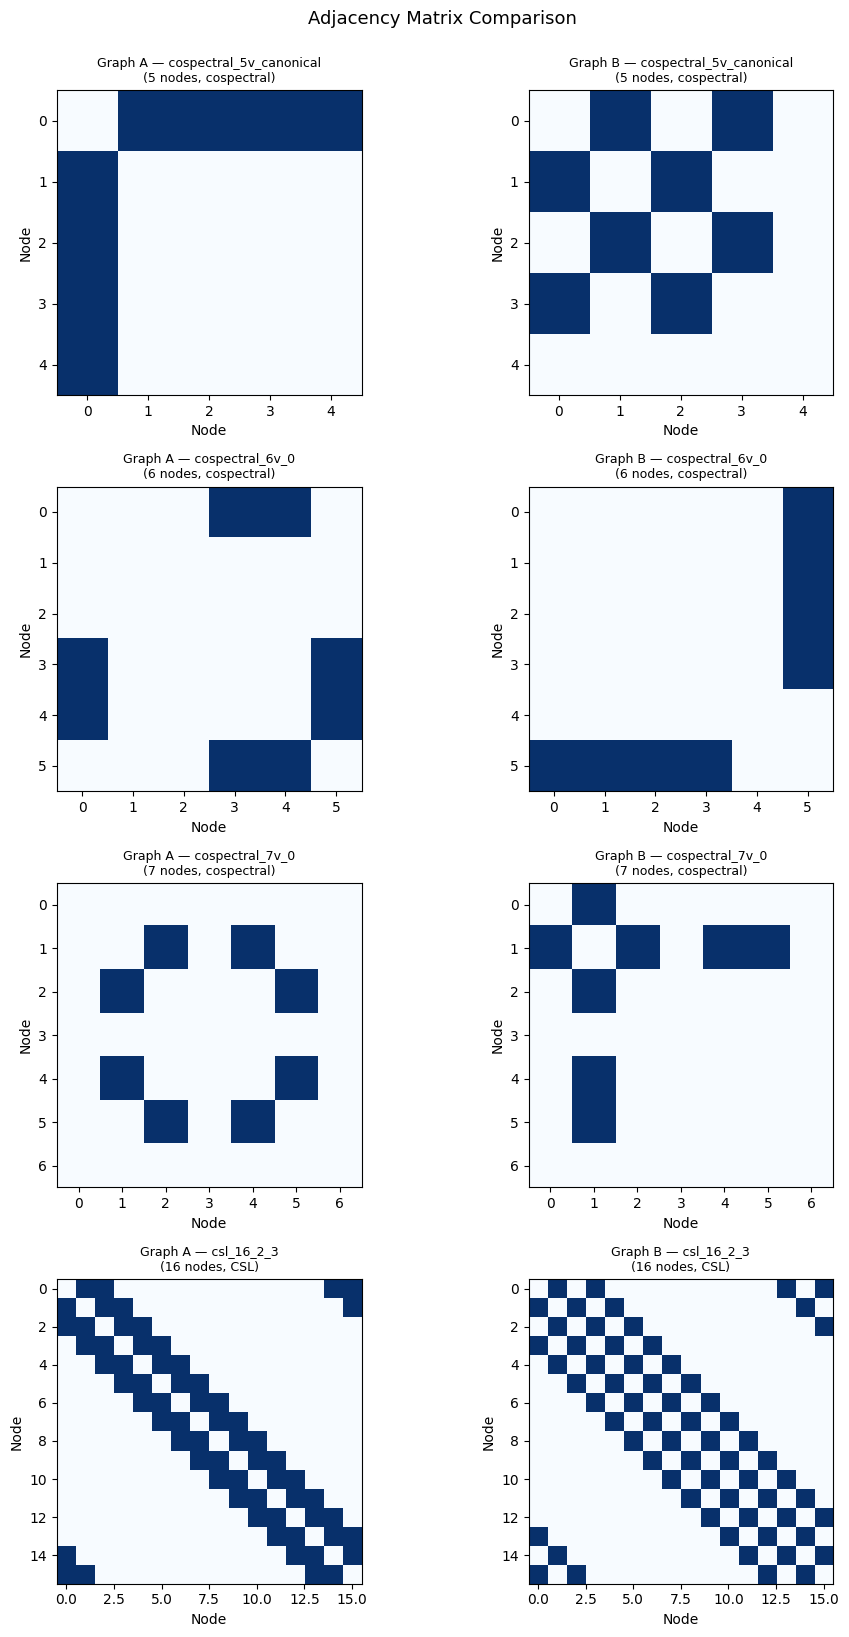

In [10]:
# Adjacency matrix heatmaps for selected pairs
adj_pairs = [p for p in parsed_pairs if p["nodes_A"] <= 16][:MAX_PAIRS_TO_VISUALIZE]

fig, axes = plt.subplots(len(adj_pairs), 2, figsize=(10, 4 * len(adj_pairs)))
if len(adj_pairs) == 1:
    axes = [axes]

for row_idx, pair in enumerate(adj_pairs):
    for col_idx, (label, adj) in enumerate([
        ("Graph A", pair["adj_A"]),
        ("Graph B", pair["adj_B"]),
    ]):
        ax = axes[row_idx][col_idx]
        im = ax.imshow(np.array(adj), cmap="Blues", vmin=0, vmax=1)
        ax.set_title(f"{label} — {pair['pair_id']}\n({pair['nodes_A']} nodes, {pair['category']})", fontsize=9)
        ax.set_xlabel("Node")
        ax.set_ylabel("Node")

plt.tight_layout()
plt.suptitle("Adjacency Matrix Comparison", fontsize=13, y=1.02)
plt.show()

## Results Summary

Final summary of the benchmark dataset with key statistics and a difficulty/WL-level distribution chart.

GRAPH EXPRESSIVENESS BENCHMARK — RESULTS SUMMARY

Dataset: Comprehensive Graph Expressiveness Benchmark Dataset
Mini demo pairs: 14
Full benchmark pairs: 525

Category                  Count    Cospectral   WL Level   Difficulty
----------------------------------------------------------------------
BREC_4Vertex              1        0/1          3-WL       hard
BREC_Basic                1        0/1          1-WL       easy
BREC_CFI                  1        0/1          3-WL       hard
BREC_Distance_Regular     1        0/1          3-WL       hard
BREC_Extension            1        0/1          2-WL       medium
BREC_Regular              1        0/1          1-WL       medium
BREC_Strongly_Regular     1        1/1          3-WL       hard
CSL                       2        0/2          1-WL       easy
cospectral                3        3/3          1-WL       easy
strongly_regular          2        2/2          2-WL       hard

Node count range: 5 - 74
Mean node count: 26.1


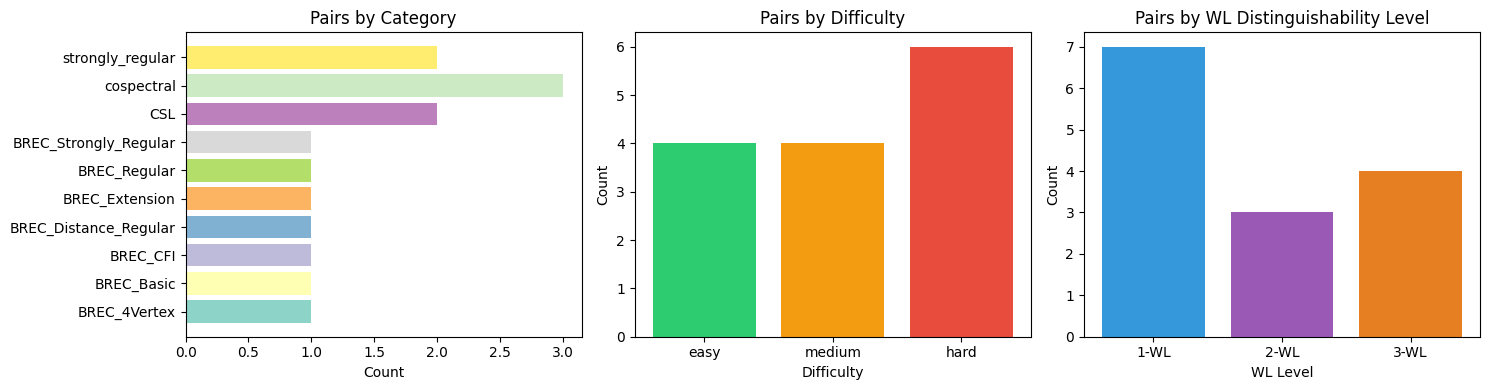


Key insight: Cospectral pairs share identical eigenvalue spectra yet are
structurally different — these are the pairs where Koopman Walk PEs aim to
succeed where spectral-invariant methods fail.


In [11]:
# Final results summary
print("=" * 70)
print("GRAPH EXPRESSIVENESS BENCHMARK — RESULTS SUMMARY")
print("=" * 70)
print(f"\nDataset: {data['metadata']['title']}")
print(f"Mini demo pairs: {len(parsed_pairs)}")
print(f"Full benchmark pairs: 525")
print()

# Results table
print(f"{'Category':<25} {'Count':<8} {'Cospectral':<12} {'WL Level':<10} {'Difficulty'}")
print("-" * 70)
for cat in sorted(set(p["category"] for p in parsed_pairs)):
    cat_pairs = [p for p in parsed_pairs if p["category"] == cat]
    n_cospec = sum(1 for p in cat_pairs if p["are_cospectral"])
    wl = cat_pairs[0]["wl_level"]
    diff = cat_pairs[0]["difficulty"]
    print(f"{cat:<25} {len(cat_pairs):<8} {n_cospec}/{len(cat_pairs):<10} {wl:<10} {diff}")

# Node size statistics
node_sizes = [p["nodes_A"] for p in parsed_pairs]
print(f"\nNode count range: {min(node_sizes)} - {max(node_sizes)}")
print(f"Mean node count: {np.mean(node_sizes):.1f}")

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Category distribution
cats = [p["category"] for p in parsed_pairs]
cat_names, cat_counts_list = zip(*sorted(collections.Counter(cats).items()))
colors = plt.cm.Set3(np.linspace(0, 1, len(cat_names)))
axes[0].barh(cat_names, cat_counts_list, color=colors)
axes[0].set_xlabel("Count")
axes[0].set_title("Pairs by Category")

# Difficulty distribution
diffs = [p["difficulty"] for p in parsed_pairs]
diff_order = ["easy", "medium", "hard"]
diff_vals = [diffs.count(d) for d in diff_order]
axes[1].bar(diff_order, diff_vals, color=["#2ecc71", "#f39c12", "#e74c3c"])
axes[1].set_xlabel("Difficulty")
axes[1].set_ylabel("Count")
axes[1].set_title("Pairs by Difficulty")

# WL-level distribution
wls = [p["wl_level"] for p in parsed_pairs]
wl_names, wl_vals = zip(*sorted(collections.Counter(wls).items()))
axes[2].bar(wl_names, wl_vals, color=["#3498db", "#9b59b6", "#e67e22"])
axes[2].set_xlabel("WL Level")
axes[2].set_ylabel("Count")
axes[2].set_title("Pairs by WL Distinguishability Level")

plt.tight_layout()
plt.show()

print("\nKey insight: Cospectral pairs share identical eigenvalue spectra yet are")
print("structurally different — these are the pairs where Koopman Walk PEs aim to")
print("succeed where spectral-invariant methods fail.")